In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns

import sys
sys.path.append('/ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/badran/src/')
import _config

sys.path.append('/home/unix/maxwshen/')
from mylib import util

notebook_nm = 'fig_compare_pacbio_to_inference'
results_dir = _config.RESULTS_PLACE + f'{notebook_nm}/'
util.ensure_dir_exists(results_dir)

Using data folder:
 /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/badran/data/


In [51]:
## Load data

true_df = pd.read_csv('/ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/badran/out/pb_e_form_dataset/badran_pacbio_pivot_1pct.csv')
true_df = true_df.rename(columns = {col: int(col.replace('hrs', '')) for col in true_df.columns if 'hrs' in col})

hrs_cols = [col for col in true_df.columns if col != 'Abbrev genotype']
idx_to_hr = {str(idx): col for idx, col in enumerate(hrs_cols)}
true_times = [s for s in true_df.columns if s != 'Abbrev genotype']
idx_to_time = {str(idx): t for idx, t in enumerate(true_times)}

true_melt_df = true_df.melt(
    id_vars = 'Abbrev genotype',
    var_name = 'Time',
    value_name = 'Frequency (%)',
)
true_melt_df = true_melt_df.rename(columns = {'Frequency (%)': 'PacBio frequency'})
pb_fq_col = 'PacBio frequency'
true_melt_df[pb_fq_col] *= 100

gts = sorted(list(set(true_df['Abbrev genotype'])))
# colors = sns.color_palette('hls', int(len(gts) * 1.5))
colors = sns.hls_palette(n_colors = int(len(gts) * 1.5), s = 0.95, l = 0.65)
master_palette = {gt: color for gt, color in zip(gts, colors)}

## Load inference

In [123]:
## Load an inference result

def load_inferred(modelexp = 'modelexp_illumina', model_id = '10', title = ''):
    prj_dir = '/ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/badran/out/_fitness_from_reads_pt_multi/'
    df = pd.read_csv(f'{prj_dir}/{modelexp}/model_{model_id}/_final_genotype_matrix.csv', index_col = 0)
    df = df.rename(columns = idx_to_time)
    
    df['Abbrev genotype'] = df.index
    df = df.reset_index(drop = True)
    
    melt_df = df.melt(
        id_vars = 'Abbrev genotype',
        var_name = 'Time',
        value_name = 'Frequency (%)',
    )
    return melt_df

ill_rl100_rs0_df = load_inferred(
    modelexp = 'modelexp_illumina', 
    model_id = '10',
)
ill_rl100_rs0_df = ill_rl100_rs0_df.rename(columns = {'Frequency (%)': 'Predicted frequency (%)'})
pred_fq_col = 'Predicted frequency (%)'
ill_rl100_rs0_df[pred_fq_col] *= 100

inference_nm = 'ill_rl100_rs0'

In [31]:
id_cols = ['Abbrev genotype', 'Time']
dfm = true_melt_df.merge(ill_rl100_rs0_df, on = id_cols, how = 'outer')
dfm = dfm.fillna(value = 0)

dfm.head()

,Abbrev genotype,Time,PacBio frequency,Predicted frequency (%)
0,VIWS.DNGE.I.YC.KS.L,0.0,0.0,0.000110
1,VIW..DNGE.I.YC.KS.L,0.0,0.0,0.001000
2,VIW...N.ERI.YC.KSKL,0.0,0.0,0.000260
3,VIWS..NGE.I.YC.KS.L,0.0,0.0,0.000131
4,VIWS.DNGE.I.YC.KSKL,0.0,0.0,0.000000


## Pearson correlation across time

In [32]:
from collections import defaultdict
from scipy.stats import pearsonr
dd = defaultdict(list)


for t in sorted(list(set(dfm['Time']))):
    dfs = dfm[dfm['Time'] == t]
    
    pr, pval = pearsonr(dfs[pb_fq_col], dfs[pred_fq_col])
    dd['Time'].append(t)
    dd['R'].append(pr)
    
stats_df = pd.DataFrame(dd)

Saving to /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/badran/results/fig_compare_pacbio_to_inference/time_r_ill_rl100_rs0.pdf ...


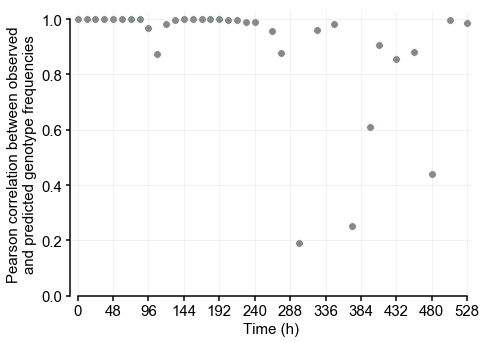

In [124]:
#
import matplotlib
matplotlib.rc('font', family = 'Arial', size = 15)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
#
fig, ax = plt.subplots(figsize = (7, 5))


sns.scatterplot(
    x = 'Time',
    y = 'R',
    data = stats_df,
    color = '#86898c',
    s = 60,
)
sns.despine()
plt.grid(alpha = 0.2)
plt.xticks(np.arange(0, 528 + 48, 48))
plt.ylim([0, 1.03])
plt.xlim([-10, 528 + 5])

plt.xlabel('Time (h)')
plt.ylabel('Pearson correlation between observed\nand predicted genotype frequencies')

plt.tight_layout()

##

sns.despine(trim = True)
ax.tick_params(length = 4.5, color = 'black', width = 1.5)
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('black')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

out_fn = results_dir + f'time_r_{inference_nm}.pdf'
print(f'Saving to {out_fn} ...')
plt.savefig(out_fn, transparent = True, bbox_inches = 'tight')

plt.show()
plt.close()
##

In [101]:
print(f'Pearsonr stats across 34 timepoints')
stats_df['R'].describe()

Pearsonr stats across 34 timepoints


count    34.000000
mean      0.902598
std       0.208538
min       0.190351
25%       0.919309
50%       0.993268
75%       0.999692
max       0.999999
Name: R, dtype: float64

Saving to /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/badran/results/fig_compare_pacbio_to_inference/time_r_strip_ill_rl100_rs0.pdf ...


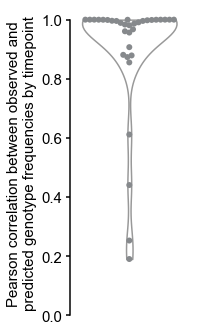

In [169]:
#
import matplotlib
matplotlib.rc('font', family = 'Arial', size = 15)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
#
fig, ax = plt.subplots(figsize = (3, 5))


sns.violinplot(
    y = 'R',
    data = stats_df,
    color = 'white',
    alpha = 0.1,
    cut = 0,
    inner = None,
    bw = 0.3,
    fliersize = 0,
)
sns.swarmplot(
    y = 'R',
    data = stats_df,
    color = '#86898c',
    alpha = 1,
    s = 6,
)
sns.despine()
# plt.grid(alpha = 0.2)
# plt.xticks(np.arange(0, 528 + 48, 48))
plt.ylim([0, 1.03])
# plt.xlim([-10, 528 + 5])
ax.xaxis.set_ticks_position('none') 

# plt.xlabel('Time (h)')
plt.ylabel('Pearson correlation between observed and\npredicted genotype frequencies by timepoint')

plt.tight_layout()

##

sns.despine(trim = True)
ax.tick_params(length = 4.5, color = 'black', width = 1.5)
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('black')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

out_fn = results_dir + f'time_r_strip_{inference_nm}.pdf'
print(f'Saving to {out_fn} ...')
plt.savefig(out_fn, transparent = True, bbox_inches = 'tight')

plt.show()
plt.close()
##

In [166]:
stats_df.sort_values(by = 'R', ascending = True).head()

,Time,R
23,300.0,0.190351
26,372.0,0.252876
31,480.0,0.440584
27,396.0,0.611445
29,432.0,0.855308


## Genotype scatter plot

Saving to /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/badran/results/fig_compare_pacbio_to_inference/gts_scatter_ill_rl100_rs0.pdf ...


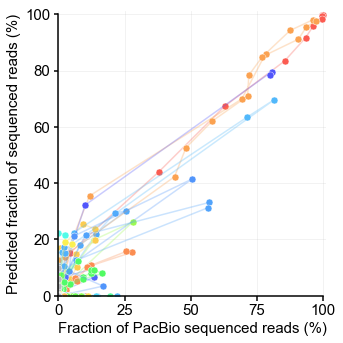

In [146]:
#
import matplotlib
matplotlib.rc('font', family = 'Arial', size = 15)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
#
fig, ax = plt.subplots(figsize = (5, 5))


for gt in set(dfm['Abbrev genotype']):
    dfs = dfm[dfm['Abbrev genotype'] == gt]
    
    # Dots
    plt.plot(
        dfs[pb_fq_col],
        dfs[pred_fq_col],
        color = master_palette[gt],
        marker = 'o',
        markeredgecolor = 'white',
        markeredgewidth = 0.5,
        markersize = 7,
        linewidth = 0,
    )
    
    # Lines
    plt.plot(
        dfs[pb_fq_col],
        dfs[pred_fq_col],
        color = master_palette[gt],
        markersize = 0,
        linewidth = 1.5,
        alpha = 0.3,
    )

sns.despine()
plt.grid(alpha = 0.2)
plt.xlabel('Fraction of PacBio sequenced reads (%)')
plt.ylabel('Predicted fraction of sequenced reads (%)')
plt.xlim(left = 0, right = 101)
plt.ylim(bottom = 0, top = 101)

plt.tight_layout()

##

sns.despine(trim = True)
ax.tick_params(length = 4.5, color = 'black', width = 1.5)
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('black')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

out_fn = results_dir + f'gts_scatter_{inference_nm}.pdf'
print(f'Saving to {out_fn} ...')
plt.savefig(out_fn, transparent = True, bbox_inches = 'tight')

plt.show()
plt.close()
##

In [99]:
print(f'Pearson correlation between predictions and observations, across all timepoints and genotypes')
pearsonr(dfm[pb_fq_col], dfm[pred_fq_col])

Pearson correlation between predictions and observations, across all timepoints and genotypes


(0.9694314921004175, 0.0)